`fetch_taxi_data` Function retrieves taxi ride data for a specified date from the database, returning the count of taxi rides per hour.<br>
Parameters:<br>
date: A string representing the date in 'YYYY-MM-DD' format.<br>
Returns:<br>
A DataFrame containing the count of taxi rides for each hour of the specified date.<br>
<br>
`animated_histogram` Function creates an animated histogram that displays the number of taxi rides per hour over a specified date range.<br>
Parameters:<br>
start_date: The start date for the animation in 'YYYY-MM-DD' format.<br>
end_date: The end date for the animation in 'YYYY-MM-DD' format.<br>
interval: The time interval (in milliseconds) between frames in the animation.<br>
filename: The filename to save the animated GIF.<br>
Internal Function `update`:<br>
`update` function updates the histogram for each frame of the animation, displaying the taxi ride counts for the current date.<br>

In [39]:
%matplotlib inline

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sqlalchemy import create_engine
from matplotlib.animation import PillowWriter
from datetime import datetime, timedelta

In [43]:
DATABASE_URL = "sqlite:///project.db"
engine = create_engine(DATABASE_URL)

In [45]:
def fetch_taxi_data(date: str) -> pd.DataFrame:
    """
    Fetches taxi ride data for a specific date from the database.

    Args:
        date (str): The date for which to fetch the taxi ride data in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: A DataFrame containing the count of taxi rides per hour for the specified date.
    """
    query = f"""
    SELECT 
        strftime('%H', tpep_pickup_datetime) AS hour,
        COUNT(*) AS ride_count
    FROM 
        taxi_trips
    WHERE 
        date(tpep_pickup_datetime) = '{date}'
    GROUP BY 
        hour
    ORDER BY 
        hour;
    """
    return pd.read_sql(query, con=engine)

def animated_histogram(start_date: str, end_date: str, interval: int, filename: str) -> None:
    """
    Creates an animated histogram of taxi rides per hour over a specified date range.

    Args:
        start_date (str): The start date for the animation in 'YYYY-MM-DD' format.
        end_date (str): The end date for the animation in 'YYYY-MM-DD' format.
        interval (int): The time interval (in milliseconds) between frames in the animation.
        filename (str): The filename to save the animated GIF.
    """
    fig, ax = plt.subplots()
    
    # Generate a range of dates from start to end
    date_range = pd.date_range(start=start_date, end=end_date)
    current_day_index = 0

    # Initialize the bar container for 24 hours
    hours = np.arange(24)
    bar_container = ax.bar(hours, np.zeros(24), color='blue', alpha=0.7)

    # Set the y-axis limit
    ax.set_ylim(0, 10)

    def update(frame: int) -> None:
        """
        Updates the histogram for each frame of the animation.

        Args:
            frame (int): The current frame number in the animation.
        """
        nonlocal current_day_index
        if current_day_index < len(date_range):
            current_date = date_range[current_day_index].date()
            new_data = fetch_taxi_data(current_date)
            counts = np.zeros(24)

            # Fill the counts array with ride counts for each hour
            for _, row in new_data.iterrows():
                hour_index = int(row['hour'])
                counts[hour_index] = min(row['ride_count'], 100)  # Limit to a maximum of 100

            # Update the heights of the bars in the histogram
            for bar, count in zip(bar_container, counts):
                bar.set_height(count)

            # Set the title for the current date
            ax.set_title(f"Taxi Rides on {current_date}")
            current_day_index += 1

        plt.draw()

    # Create the animation
    anim = FuncAnimation(fig, update, frames=len(date_range), interval=interval)
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Number of Rides")

    # Save the animation as a GIF file
    anim.save(filename, writer=PillowWriter(fps=10))
    plt.show()

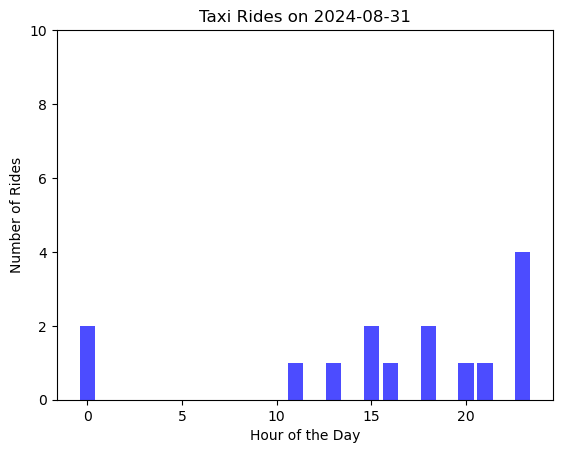

In [47]:
# Define the start and end dates for the animation
start_date = "2020-01-01"
end_date = "2024-08-31"

# Run the animated histogram function
animated_histogram(start_date, end_date, interval=100, filename='taxi_rides_animation.gif')